#### Changing Working Directory

In [14]:
import os

In [15]:
curr_dir = os.getcwd()
parent_dir = os.path.dirname(curr_dir)

In [16]:
os.chdir(parent_dir)

In [17]:
os.getcwd()

'/Users/aadesh/Desktop/codeground/machine_learning/sentiment_analysis'

In [86]:
plots_dir = os.path.join(parent_dir, 'plots')

#### Data porcessing and Model Training

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import xgboost as xgb
import pickle
import os
import re
from textblob import TextBlob

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
def load_data(file_path):
    df = pd.read_csv(file_path, sep='\t')
    return df

In [21]:
def clean_text(text):
    """Clean and preprocess text while preserving sentiment indicators"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    

    text = re.sub(r'!{2,}', ' MULTIPLE_EXCLAMATION ', text)  
    text = re.sub(r'!', ' EXCLAMATION ', text)  
    text = re.sub(r'\?{2,}', ' MULTIPLE_QUESTION ', text)  
    text = re.sub(r'\?', ' QUESTION ', text)  
    
    negations = ['not', 'no', 'never', 'nothing', 'nowhere', 'noone', 'none', 'neither', 'nobody', 'cannot', "can't", "won't", "shouldn't", "wouldn't", "couldn't", "doesn't", "don't", "didn't", "isn't", "aren't", "wasn't", "weren't"]
    for neg in negations:
        text = re.sub(rf'\b{neg}\b', f'NEG_{neg.upper()}', text)
    
    text = re.sub(r'[^a-zA-Z\s_]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [22]:
def create_sentiment_labels(df):
    """Create sentiment labels based on ratings and text sentiment"""
    conditions = [
        df['rating'] <= 2,
        df['rating'] == 3,
        df['rating'] >= 4
    ]
    choices = [0, 1, 2]  
    df['sentiment'] = np.select(conditions, choices)
    
    for idx, row in df.iterrows():
        if pd.notna(row['verified_reviews']):
            blob = TextBlob(str(row['verified_reviews']))
            text_sentiment = blob.sentiment.polarity
            
            if row['rating'] >= 4 and text_sentiment < -0.3:  
                df.at[idx, 'sentiment'] = 0  
            elif row['rating'] <= 2 and text_sentiment > 0.3:  
                df.at[idx, 'sentiment'] = 2  
    
    return df

In [23]:
def preprocess_data(df):
    """Complete data preprocessing pipeline"""
    df['cleaned_reviews'] = df['verified_reviews'].apply(clean_text)
    df = df[df['cleaned_reviews'] != ''].reset_index(drop=True)
    df = create_sentiment_labels(df)
    
    return df

In [24]:
def handle_class_imbalance(X, y, method='smote'):
    """Handle class imbalance using various techniques"""
    print(f"Original class distribution: {np.bincount(y)}")
    
    if method == 'smote':
        smote = SMOTE(random_state=42, k_neighbors=3)
        X_balanced, y_balanced = smote.fit_resample(X, y)
    elif method == 'smote_tomek':
        smote_tomek = SMOTETomek(random_state=42)
        X_balanced, y_balanced = smote_tomek.fit_resample(X, y)
    else:
        X_balanced, y_balanced = X, y
    
    print(f"Balanced class distribution: {np.bincount(y_balanced)}")
    return X_balanced, y_balanced

In [25]:
def prepare_features(df):
    """Prepare features using improved TF-IDF"""
    vectorizer = TfidfVectorizer(
        max_features=10000,  
        stop_words='english',
        ngram_range=(1, 3),  
        min_df=2,  
        max_df=0.8,  
        sublinear_tf=True  
    )
    
    X = vectorizer.fit_transform(df['cleaned_reviews'])
    y = df['sentiment']
    
    return X, y, vectorizer

In [26]:
def train_models(X_train, y_train):
    """Train multiple models with class balancing"""
    models = {
        'Logistic Regression': LogisticRegression(
            random_state=42, 
            max_iter=1000,
            class_weight='balanced'  
        ),
        'SVM Linear': SVC(
            kernel='linear', 
            random_state=42, 
            probability=True,
            class_weight='balanced'  
        ),
        'SVM RBF': SVC(
            kernel='rbf', 
            random_state=42, 
            probability=True,
            class_weight='balanced',  
            gamma='scale'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100, 
            random_state=42,
            class_weight='balanced',
            max_depth=10
        ),
        'XGBoost': xgb.XGBClassifier(
            random_state=42, 
            eval_metric='mlogloss',
            scale_pos_weight=1  
        )
    }
    
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    weight_dict = dict(zip(classes, class_weights))
    
    sample_weights = np.array([weight_dict[y] for y in y_train])
    
    trained_models = {}
    for name, model in models.items():
        print(f"Training {name}...")
        if name == 'XGBoost':
            model.fit(X_train, y_train, sample_weight=sample_weights)
        else:
            model.fit(X_train, y_train)
        trained_models[name] = model
    
    return trained_models

In [27]:
def evaluate_models(models, X_train, X_test, y_train, y_test):
    """Evaluate all models with comprehensive metrics"""
    results = {}
    
    for name, model in models.items():
        train_pred = model.predict(X_train)
        train_acc = accuracy_score(y_train, train_pred)
        train_balanced_acc = balanced_accuracy_score(y_train, train_pred)
        
        test_pred = model.predict(X_test)
        test_acc = accuracy_score(y_test, test_pred)
        test_balanced_acc = balanced_accuracy_score(y_test, test_pred)
        
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
        cv_mean = cv_scores.mean()
        
        precision, recall, f1, support = precision_recall_fscore_support(y_test, test_pred, average=None)
        macro_f1 = precision_recall_fscore_support(y_test, test_pred, average='macro')[2]
        
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(X_test)
            confidence = np.mean(np.max(probabilities, axis=1))
        else:
            confidence = 0.0
        
        results[name] = {
            'train_accuracy': train_acc,
            'train_balanced_accuracy': train_balanced_acc,
            'test_accuracy': test_acc,
            'test_balanced_accuracy': test_balanced_acc,
            'cv_score': cv_mean,
            'cv_std': cv_scores.std(),
            'confidence': confidence,
            'macro_f1': macro_f1,
            'precision_per_class': precision,
            'recall_per_class': recall,
            'f1_per_class': f1
        }
        
        print(f"\n{name} Results:")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Balanced Accuracy: {test_balanced_acc:.4f}")
        print(f"CV Score: {cv_mean:.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"Macro F1: {macro_f1:.4f}")
        print(f"Per-class F1: Neg={f1[0]:.3f}, Neu={f1[1]:.3f}, Pos={f1[2]:.3f}")
    
    return results

In [87]:
def save_and_show_plots(title):
    filename = title.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_') + ".png"
    file_path = os.path.join(plots_dir, filename)
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

In [88]:
def plot_model_comparison(results):
    """Create individual comparison plots"""
    models = list(results.keys())
    
    # Prepare data for plotting
    test_acc = [results[model]['test_accuracy'] for model in models]
    balanced_acc = [results[model]['test_balanced_accuracy'] for model in models]
    cv_scores = [results[model]['cv_score'] for model in models]
    macro_f1 = [results[model]['macro_f1'] for model in models]
    
    # Plot 1: Regular Test Accuracy
    plt.figure(figsize=(8, 6))
    bars1 = plt.bar(models, test_acc, color='skyblue', alpha=0.8, edgecolor='black')
    title1 = 'Regular Test Accuracy Comparison'
    plt.title(title1, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    # Add value labels on bars
    for bar, acc in zip(bars1, test_acc):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    save_and_show_plots(title1)
    
    # Plot 2: Balanced Test Accuracy (More important for imbalanced data)
    plt.figure(figsize=(8, 6))
    bars2 = plt.bar(models, balanced_acc, color='lightcoral', alpha=0.8, edgecolor='black')
    title2 = 'Balanced Test Accuracy (Better Metric for Imbalanced Data)'
    plt.title(title2, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Balanced Accuracy', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    # Add value labels on bars
    for bar, acc in zip(bars2, balanced_acc):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    save_and_show_plots(title2)
    
    # Plot 3: CV Scores
    plt.figure(figsize=(10, 6))
    bars3 = plt.bar(models, cv_scores, color='lightgreen', alpha=0.8, edgecolor='black')
    title3 = 'Cross-Validation Score Comparison'
    plt.title(title3, fontsize=16, fontweight='bold', pad=28)
    plt.ylabel('CV Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    # Add value labels on bars
    for bar, cv in zip(bars3, cv_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{cv:.3f}', ha='center', va='bottom', fontweight='bold')
    save_and_show_plots(title3)
    
    # Plot 4: Macro F1 Score
    plt.figure(figsize=(8, 6))
    bars4 = plt.bar(models, macro_f1, color='gold', alpha=0.8, edgecolor='black')
    title4 = 'Macro F1 Score Comparison'
    plt.title(title4, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('F1 Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    # Add value labels on bars
    for bar, f1 in zip(bars4, macro_f1):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
    save_and_show_plots(title4)
    
    # Plot 5: Per-class F1 comparison for best model
    best_model = max(models, key=lambda x: results[x]['test_balanced_accuracy'])
    f1_scores = results[best_model]['f1_per_class']
    classes = ['Negative', 'Neutral', 'Positive']
    colors = ['#FF6B6B', '#FFE66D', '#4ECDC4']
    
    plt.figure(figsize=(8, 6))
    bars5 = plt.bar(classes, f1_scores, color=colors, alpha=0.8, edgecolor='black')
    title5 = 'Per-Class F1 Scores - Best Model'
    plt.title(f'{title5}: {best_model}', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('F1 Score', fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    # Add value labels on bars
    for bar, f1 in zip(bars5, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
    save_and_show_plots(title5)
    
    # Plot 6: Combined Performance Comparison
    x = np.arange(len(models))
    width = 0.25
    
    plt.figure(figsize=(9, 6))
    bars6a = plt.bar(x - width, test_acc, width, label='Regular Accuracy', color='skyblue', alpha=0.8, edgecolor='black')
    bars6b = plt.bar(x, balanced_acc, width, label='Balanced Accuracy', color='lightcoral', alpha=0.8, edgecolor='black')
    bars6c = plt.bar(x + width, macro_f1, width, label='Macro F1', color='gold', alpha=0.8, edgecolor='black')
    title6 = 'Comprehensive Performance Comparison'
    plt.title(title6, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Models', fontsize=12)
    plt.xticks(x, models, rotation=45, ha='right')
    plt.legend(fontsize=11)
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    save_and_show_plots(title6)
    
    # Print best model summary
    print(f"\n{'='*60}")
    print(f"BEST MODEL SUMMARY")
    print(f"{'='*60}")
    print(f"Best model by balanced accuracy: {best_model}")
    print(f"Balanced Accuracy: {results[best_model]['test_balanced_accuracy']:.4f}")
    print(f"Macro F1: {results[best_model]['macro_f1']:.4f}")
    print(f"Per-class performance:")
    print(f"  Negative F1: {results[best_model]['f1_per_class'][0]:.3f}")
    print(f"  Neutral F1:  {results[best_model]['f1_per_class'][1]:.3f}")
    print(f"  Positive F1: {results[best_model]['f1_per_class'][2]:.3f}")

In [29]:
def save_models(models, vectorizer, save_dir='trained_models'):
    """Save trained models"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    with open(f'{save_dir}/vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
    
    for name, model in models.items():
        filename = f"{save_dir}/{name.replace(' ', '_').lower()}.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(model, f)
        print(f"Saved {name} to {filename}")

In [30]:
def load_models(save_dir='trained_models'):
    """Load saved models"""
    models = {}
    
    with open(f'{save_dir}/vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    
    model_files = {
        'Logistic Regression': 'logistic_regression.pkl',
        'SVM Linear': 'svm_linear.pkl',
        'SVM RBF': 'svm_rbf.pkl',
        'Random Forest': 'random_forest.pkl',
        'XGBoost': 'xgboost.pkl'
    }
    
    for name, filename in model_files.items():
        with open(f'{save_dir}/{filename}', 'rb') as f:
            models[name] = pickle.load(f)
    
    return models, vectorizer

In [31]:
def predict_sentiment(text, model, vectorizer):
    """Predict sentiment for a single text"""
    cleaned_text = clean_text(text)
    text_vector = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vector)[0]
    
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_map[prediction]

In [32]:
def test_models_with_samples(models, vectorizer):
    """Test models with sample reviews"""
    sample_reviews = [
        "This Alexa is absolutely amazing! Best purchase ever!",            # Positive
        "Love the sound quality and voice recognition is perfect",          # Positive
        "It's okay, nothing special but does the job",                      # Neutral
        "Average product, some features work some don't",                   # Neutral
        "Terrible sound quality, waste of money",                           # Negative
        "Worst Alexa ever, doesn't understand anything I say",              # Negative
        "Great device, highly recommend to everyone!",                      # Positive
        "Not worth the price, expected much better"                         # Negative
    ]
    
    print("\n" + "="*80)
    print("TESTING MODELS WITH SAMPLE REVIEWS")
    print("="*80)
    
    for i, review in enumerate(sample_reviews, 1):
        print(f"\nSample {i}: {review}")
        print("-" * 50)
        
        for name, model in models.items():
            prediction = predict_sentiment(review, model, vectorizer)
            print(f"{name:20}: {prediction}")

In [38]:
print("Loading data...")
df = load_data('data/alexa_reviews/amazon_alexa.tsv')

Loading data...


In [39]:
print("Preprocessing data...")
df_processed = preprocess_data(df)

Preprocessing data...


In [40]:
print(f"Dataset shape: {df_processed.shape}")
print(f"Sentiment distribution:\n{df_processed['sentiment'].value_counts()}")


Dataset shape: (3065, 7)
Sentiment distribution:
sentiment
2    2702
0     223
1     140
Name: count, dtype: int64


In [41]:
print("\nPreparing features...")
X, y, vectorizer = prepare_features(df_processed)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Preparing features...


In [42]:
print("\nHandling class imbalance...")
X_train_balanced, y_train_balanced = handle_class_imbalance(X_train, y_train, method='smote')


Handling class imbalance...
Original class distribution: [ 178  112 2162]
Balanced class distribution: [2162 2162 2162]


In [43]:
print("\nTraining models...")
trained_models = train_models(X_train_balanced, y_train_balanced)


Training models...
Training Logistic Regression...
Training SVM Linear...
Training SVM RBF...
Training Random Forest...
Training XGBoost...


In [44]:
print("\nEvaluating models...")
results = evaluate_models(trained_models, X_train_balanced, X_test, y_train_balanced, y_test)


Evaluating models...

Logistic Regression Results:
Test Accuracy: 0.9233
Balanced Accuracy: 0.7427
CV Score: 0.9877 (+/- 0.0038)
Macro F1: 0.7380
Per-class F1: Neg=0.651, Neu=0.600, Pos=0.963

SVM Linear Results:
Test Accuracy: 0.9282
Balanced Accuracy: 0.7220
CV Score: 0.9923 (+/- 0.0026)
Macro F1: 0.7522
Per-class F1: Neg=0.667, Neu=0.627, Pos=0.962

SVM RBF Results:
Test Accuracy: 0.9266
Balanced Accuracy: 0.6195
CV Score: 0.9988 (+/- 0.0021)
Macro F1: 0.7071
Per-class F1: Neg=0.433, Neu=0.727, Pos=0.961

Random Forest Results:
Test Accuracy: 0.8825
Balanced Accuracy: 0.5488
CV Score: 0.8813 (+/- 0.0465)
Macro F1: 0.5682
Per-class F1: Neg=0.460, Neu=0.304, Pos=0.941

XGBoost Results:
Test Accuracy: 0.9380
Balanced Accuracy: 0.7415
CV Score: 0.9752 (+/- 0.0525)
Macro F1: 0.7627
Per-class F1: Neg=0.762, Neu=0.556, Pos=0.971



Creating comparison plots...


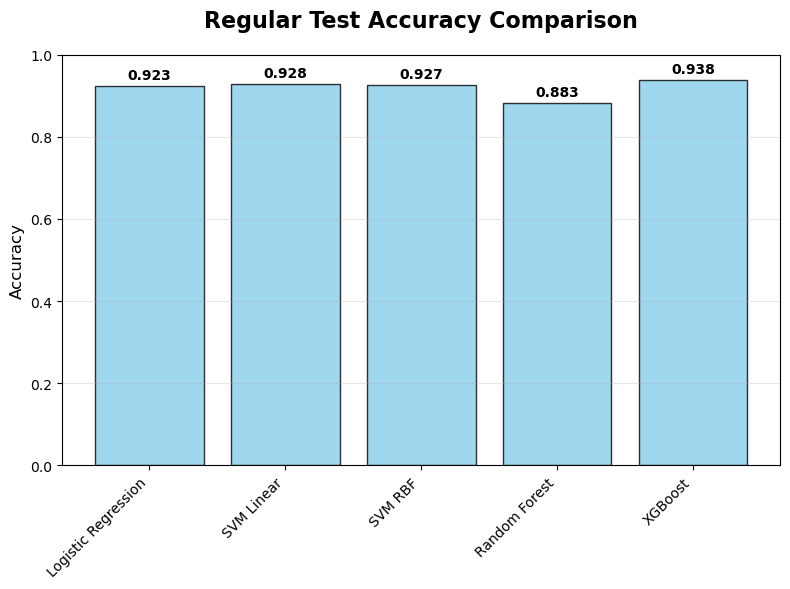

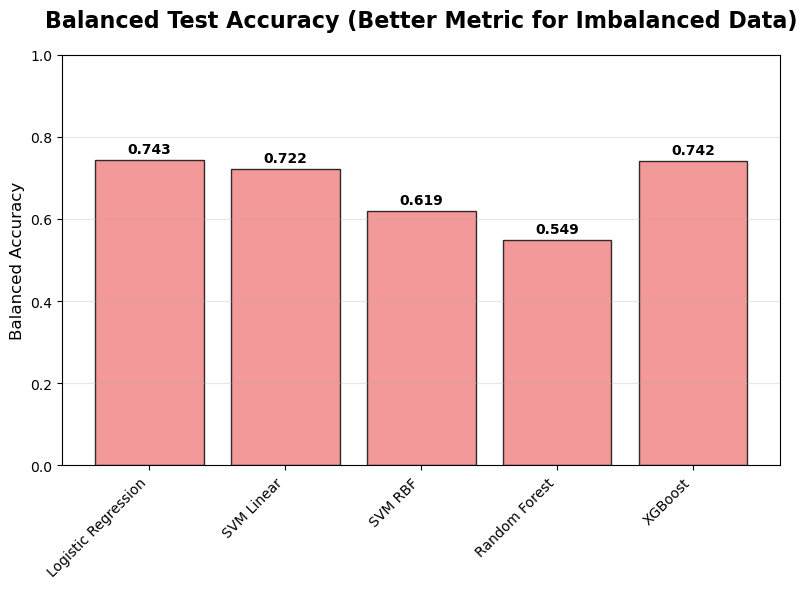

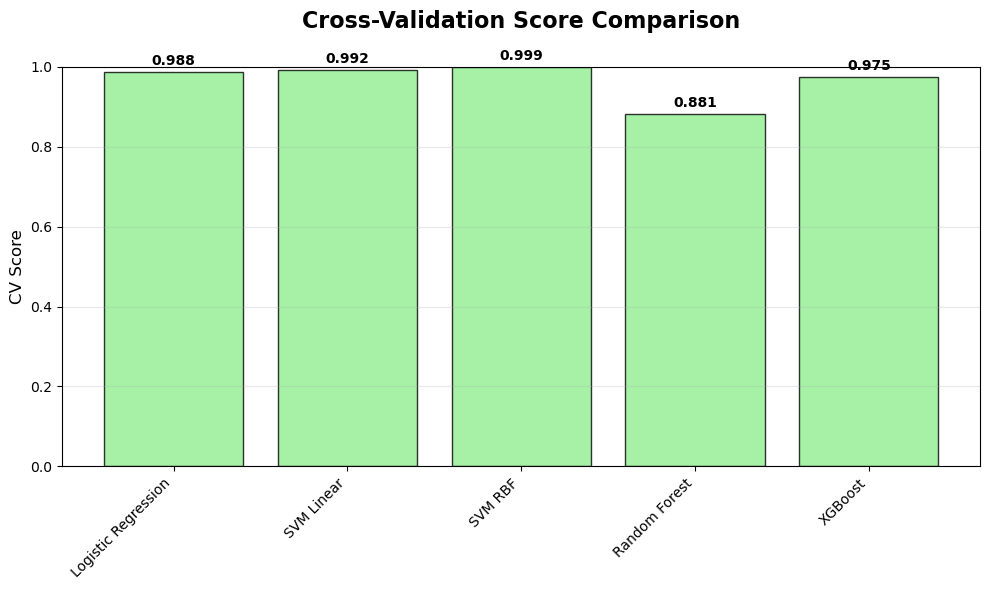

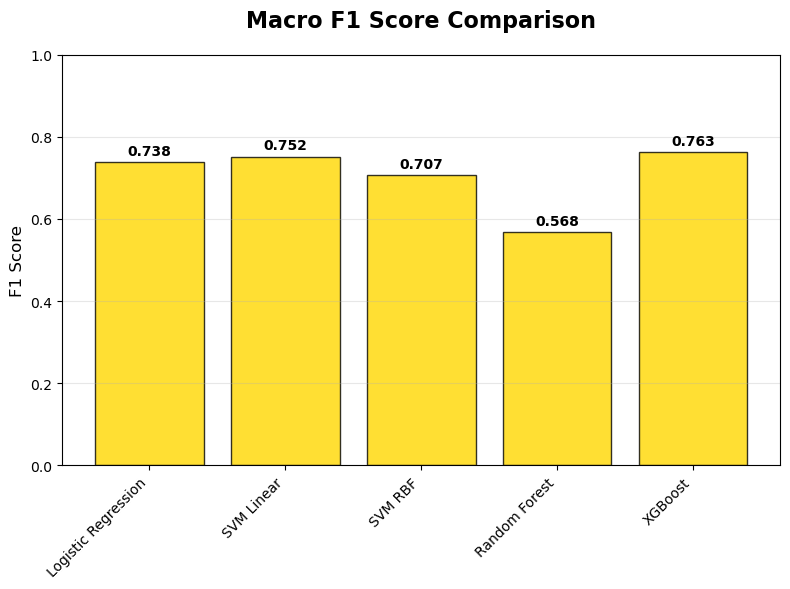

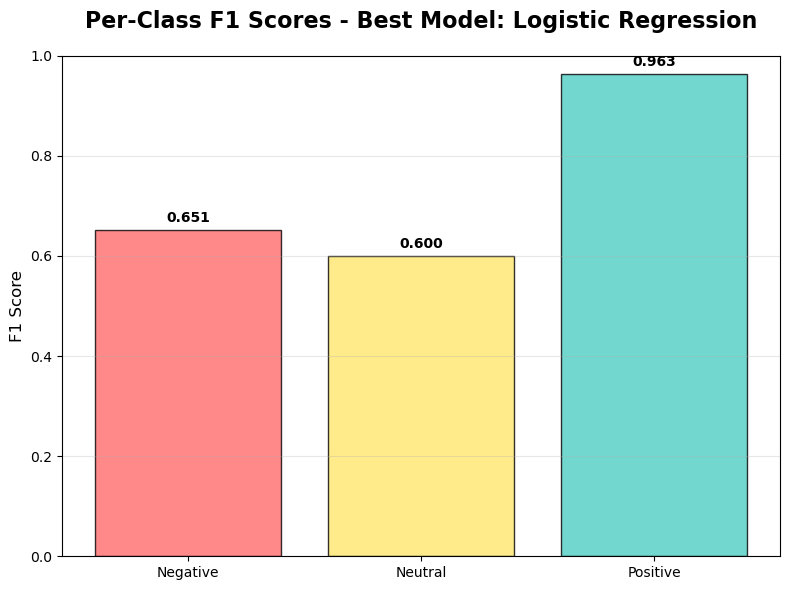

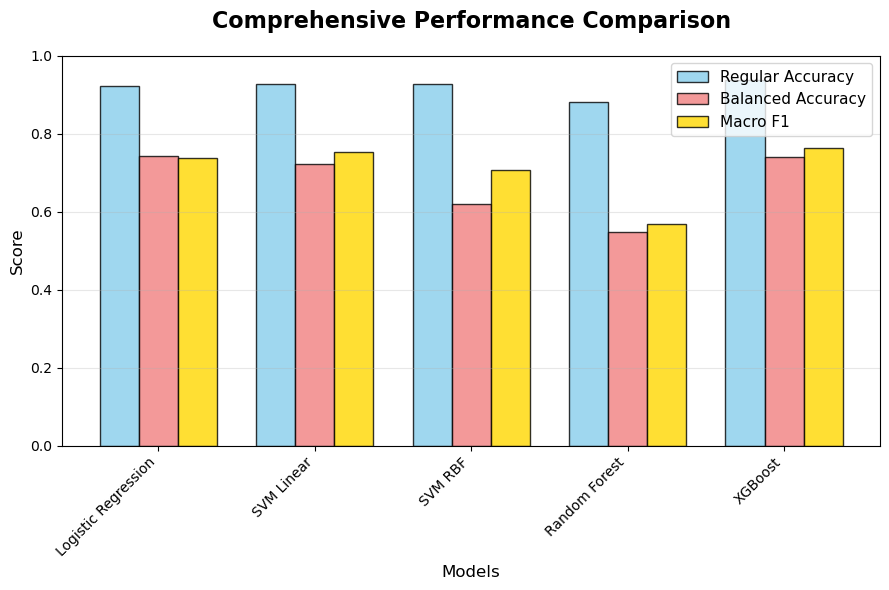


BEST MODEL SUMMARY
Best model by balanced accuracy: Logistic Regression
Balanced Accuracy: 0.7427
Macro F1: 0.7380
Per-class performance:
  Negative F1: 0.651
  Neutral F1:  0.600
  Positive F1: 0.963


In [89]:
print("\nCreating comparison plots...")
plot_model_comparison(results)

In [46]:
# Save models
print("\nSaving models...")
save_models(trained_models, vectorizer)


Saving models...
Saved Logistic Regression to trained_models/logistic_regression.pkl
Saved SVM Linear to trained_models/svm_linear.pkl
Saved SVM RBF to trained_models/svm_rbf.pkl
Saved Random Forest to trained_models/random_forest.pkl
Saved XGBoost to trained_models/xgboost.pkl


In [47]:
print("\nTraining completed successfully!")


Training completed successfully!


In [48]:
def test_saved_models():
    """Load and test saved models"""
    print("Loading saved models...")
    models, vectorizer = load_models()
    
    # Test with sample reviews
    test_models_with_samples(models, vectorizer)

In [49]:
test_saved_models()

Loading saved models...

TESTING MODELS WITH SAMPLE REVIEWS

Sample 1: This Alexa is absolutely amazing! Best purchase ever!
--------------------------------------------------
Logistic Regression : Positive
SVM Linear          : Positive
SVM RBF             : Positive
Random Forest       : Positive
XGBoost             : Positive

Sample 2: Love the sound quality and voice recognition is perfect
--------------------------------------------------
Logistic Regression : Positive
SVM Linear          : Positive
SVM RBF             : Positive
Random Forest       : Positive
XGBoost             : Positive

Sample 3: It's okay, nothing special but does the job
--------------------------------------------------
Logistic Regression : Positive
SVM Linear          : Positive
SVM RBF             : Positive
Random Forest       : Positive
XGBoost             : Positive

Sample 4: Average product, some features work some don't
--------------------------------------------------
Logistic Regression : Nega